# Causal Interventions

Hypothesis: The same neurons will activate for 'Paris' whether queried in English or Tagalog or German 
I took this from the suggestions on the markdown, I think it's a really interesting hypothesis to test in this context.

In [4]:
# TransformerLens has built-in logit lens support
from transformer_lens import HookedTransformer

model = HookedTransformer.from_pretrained("gpt2-medium")
tokens = model.to_tokens("The capital of France is")
logits, cache = model.run_with_cache(tokens)

# Project each layer's residual stream to vocabulary
for layer in range(model.cfg.n_layers):
    residual = cache[f"blocks.{layer}.hook_resid_post"]
    layer_logits = model.unembed(model.ln_final(residual))
    top_tokens = layer_logits[0, -1].topk(5)
    print(f"Layer {layer}: {model.to_str_tokens(top_tokens.indices)}")

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-medium into HookedTransformer
Layer 0: [' not', ' also', ' currently', ' often', ' in']
Layer 1: [' not', ' currently', ' also', ' often', ' typically']
Layer 2: [' not', ' currently', ' now', ' also', ' in']
Layer 3: [' not', ' currently', ' now', ' also', ' often']
Layer 4: [' not', ' currently', ' now', ' in', ' largely']
Layer 5: [' not', ' currently', ' now', ' in', ' largely']
Layer 6: [' not', ' currently', ' now', ' often', ' in']
Layer 7: [' not', ' currently', ' now', ' often', ' in']
Layer 8: [' often', ' currently', ' now', ' not', ' in']
Layer 9: [' now', ' not', ' often', ' in', ' always']
Layer 10: [' now', ' not', ' often', ' always', ' in']
Layer 11: [' now', ' not', ' often', ' officially', ' currently']
Layer 12: [' often', ' not', ' now', ' always', ' also']
Layer 13: [' not', ' now', ' often', ' always', ' also']
Layer 14: [' now', ' not', ' officially', ' often', ' also']
Layer 15: [' now', ' often', ' not', ' always', ' officially']
L

Starting out, let's just experiment with how activation patching is done in Transformer Lens

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformer_lens import HookedTransformer

In [3]:
model = HookedTransformer.from_pretrained("bloom-560m")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model bloom-560m into HookedTransformer


In [4]:
clean_prompt = "The capitol of France is"
corrupted_prompt = "The capitol of Russia is"

clean_answer = " Paris"
corrupted_answer = " Moscow"

In [21]:
# Convert answers to token IDs
clean_token = model.to_single_token(clean_answer)
corrupted_token = model.to_single_token(corrupted_answer)

# Tokenize prompts (ensure they are same length)
# We need the tokens to loop over positions
clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)
n_layers = model.cfg.n_layers
n_pos = clean_tokens.shape[1]

In [22]:
# print out sizes of tokens to make sure they match
print("Clean tokens shape:", clean_tokens.shape)
print("Corrupted tokens shape:", corrupted_tokens.shape)

Clean tokens shape: torch.Size([1, 6])
Corrupted tokens shape: torch.Size([1, 6])


In [23]:
# Clean Cache (Source of the patch)
_, clean_cache = model.run_with_cache(clean_prompt)

In [24]:
# Corrupted Run (Baseline to measure against)
corrupted_logits = model(corrupted_prompt)
base_score = (corrupted_logits[0, -1, clean_token] - 
              corrupted_logits[0, -1, corrupted_token]).item()

In [25]:
print(f"Baseline Score (Corrupted): {base_score:.2f}")

Baseline Score (Corrupted): -0.90


In [26]:
def make_patch_hook(position):
    def hook(corrupted_resid, hook):
        # corrupted_resid shape: [batch, pos, d_model]
        # We only overwrite the slice at 'position'
        corrupted_resid[:, position, :] = clean_cache[hook.name][:, position, :]
        return corrupted_resid
    return hook

In [27]:
# 4. The Main Loop (Layer x Position)
# Initialize a matrix to hold our results
english_heatmap_data = np.zeros((n_layers, n_pos))
english_base_score = base_score
english_str_tokens = model.to_str_tokens(clean_prompt)

print("Running patching sweep for English... (This may take a minute)")

for layer in range(n_layers):
    for pos in range(n_pos):
        # We target the Residual Stream output at this specific layer
        hook_name = f"blocks.{layer}.hook_resid_post"
        
        # Run the model with the hook active only at this specific layer and position
        patched_logits = model.run_with_hooks(
            corrupted_prompt,
            fwd_hooks=[(hook_name, make_patch_hook(pos))]
        )
        
        # Calculate metric: Did the model switch to "Paris"?
        score = (patched_logits[0, -1, clean_token] - 
                 patched_logits[0, -1, corrupted_token]).item()
        
        # Store result normalized against the baseline
        english_heatmap_data[layer, pos] = score

print("English patching complete!")

Running patching sweep for English... (This may take a minute)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 20.81 MiB is free. Including non-PyTorch memory, this process has 5.14 GiB memory in use. Of the allocated memory 5.01 GiB is allocated by PyTorch, and 21.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

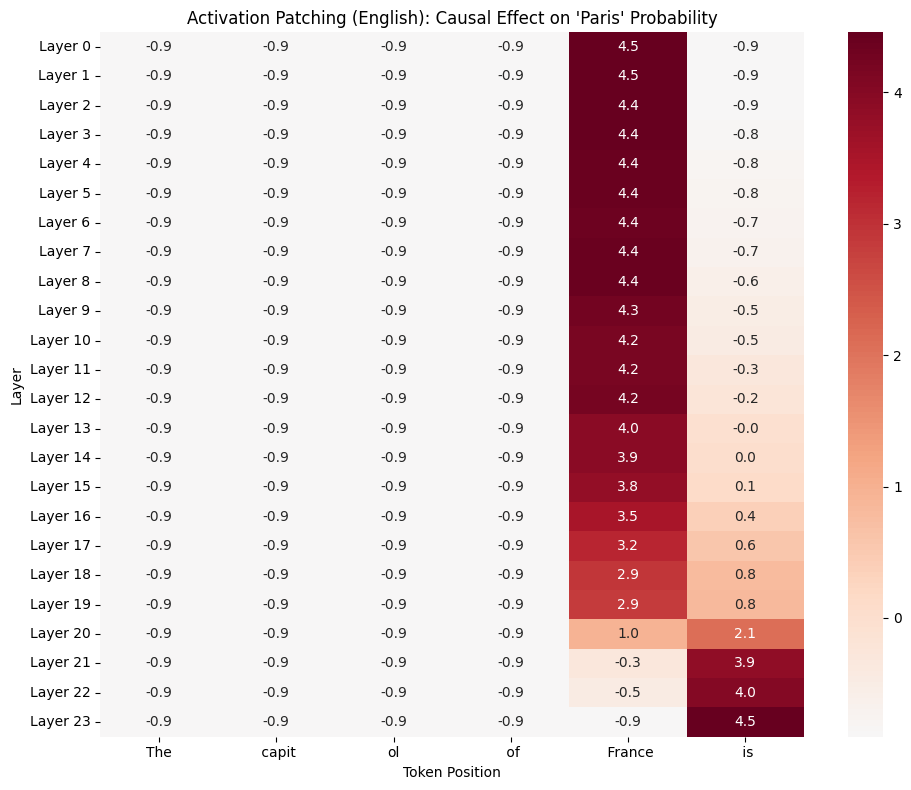

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    english_heatmap_data, 
    annot=True, 
    fmt=".1f", 
    xticklabels=english_str_tokens, 
    yticklabels=[f"Layer {i}" for i in range(n_layers)],
    cmap="RdBu_r", 
    center=english_base_score
)
plt.title("Activation Patching (English): Causal Effect on 'Paris' Probability")
plt.xlabel("Token Position")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

In [ ]:
clean_prompt = "Ang kapitolyo ng France ay"
corrupted_prompt = "Ang kapitolyo ng Moscow ay"

clean_answer = " Paris"
corrupted_answer = " Moscow"

In [28]:
# Convert answers to token IDs
clean_token = model.to_single_token(clean_answer)
corrupted_token = model.to_single_token(corrupted_answer)

# Tokenize prompts (ensure they are same length)
# We need the tokens to loop over positions
clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)
n_layers = model.cfg.n_layers
n_pos = clean_tokens.shape[1]

In [29]:
print("Clean tokens shape:", clean_tokens.shape)
print("Corrupted tokens shape:", corrupted_tokens.shape)

Clean tokens shape: torch.Size([1, 6])
Corrupted tokens shape: torch.Size([1, 6])


In [30]:
# Clean Cache (Source of the patch)
_, clean_cache = model.run_with_cache(clean_prompt)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 24.38 MiB is free. Including non-PyTorch memory, this process has 5.16 GiB memory in use. Of the allocated memory 5.04 GiB is allocated by PyTorch, and 22.07 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Corrupted Run (Baseline to measure against)
corrupted_logits = model(corrupted_prompt)
base_score = (corrupted_logits[0, -1, clean_token] - 
              corrupted_logits[0, -1, corrupted_token]).item()

In [19]:
print(f"Baseline Score (Corrupted): {base_score:.2f}")

Baseline Score (Corrupted): -1.06


In [20]:
def make_patch_hook(position):
    def hook(corrupted_resid, hook):
        # corrupted_resid shape: [batch, pos, d_model]
        # We only overwrite the slice at 'position'
        corrupted_resid[:, position, :] = clean_cache[hook.name][:, position, :]
        return corrupted_resid
    return hook

In [21]:
# 4. The Main Loop (Layer x Position)
# Initialize a matrix to hold our results
tagalog_heatmap_data = np.zeros((n_layers, n_pos))
tagalog_base_score = base_score
tagalog_str_tokens = model.to_str_tokens(clean_prompt)
tagalog_n_pos = n_pos

print("Running patching sweep for Tagalog... (This may take a minute)")

for layer in range(n_layers):
    for pos in range(n_pos):
        # We target the Residual Stream output at this specific layer
        hook_name = f"blocks.{layer}.hook_resid_post"
        
        # Run the model with the hook active only at this specific layer and position
        patched_logits = model.run_with_hooks(
            corrupted_prompt,
            fwd_hooks=[(hook_name, make_patch_hook(pos))]
        )
        
        # Calculate metric: Did the model switch to "Paris"?
        score = (patched_logits[0, -1, clean_token] - 
                 patched_logits[0, -1, corrupted_token]).item()
        
        # Store result normalized against the baseline
        tagalog_heatmap_data[layer, pos] = score

print("Tagalog patching complete!")

Running patching sweep for Tagalog... (This may take a minute)
Tagalog patching complete!


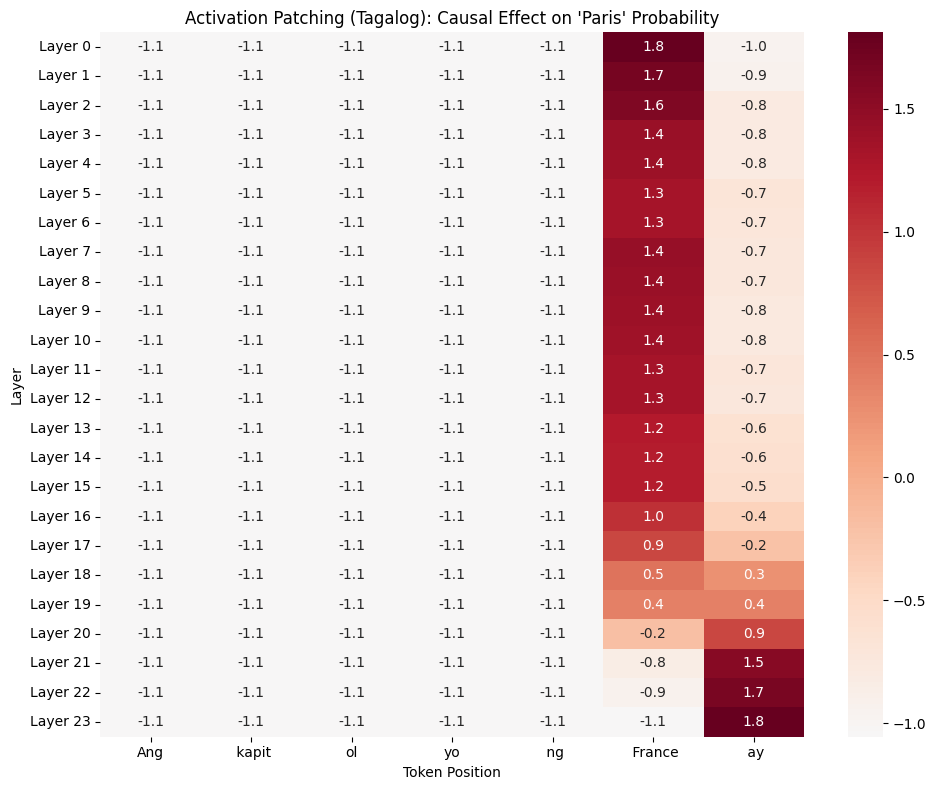

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    tagalog_heatmap_data, 
    annot=True, 
    fmt=".1f", 
    xticklabels=tagalog_str_tokens, 
    yticklabels=[f"Layer {i}" for i in range(n_layers)],
    cmap="RdBu_r", 
    center=tagalog_base_score
)
plt.title("Activation Patching (Tagalog): Causal Effect on 'Paris' Probability")
plt.xlabel("Token Position")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

## Comparison: English vs Tagalog Activation Patching

Now let's compare the activation patterns between English and Tagalog to test our hypothesis: do the same neurons activate for 'Paris' regardless of language?

In [23]:
import os
os.makedirs("lab3_plots", exist_ok=True)

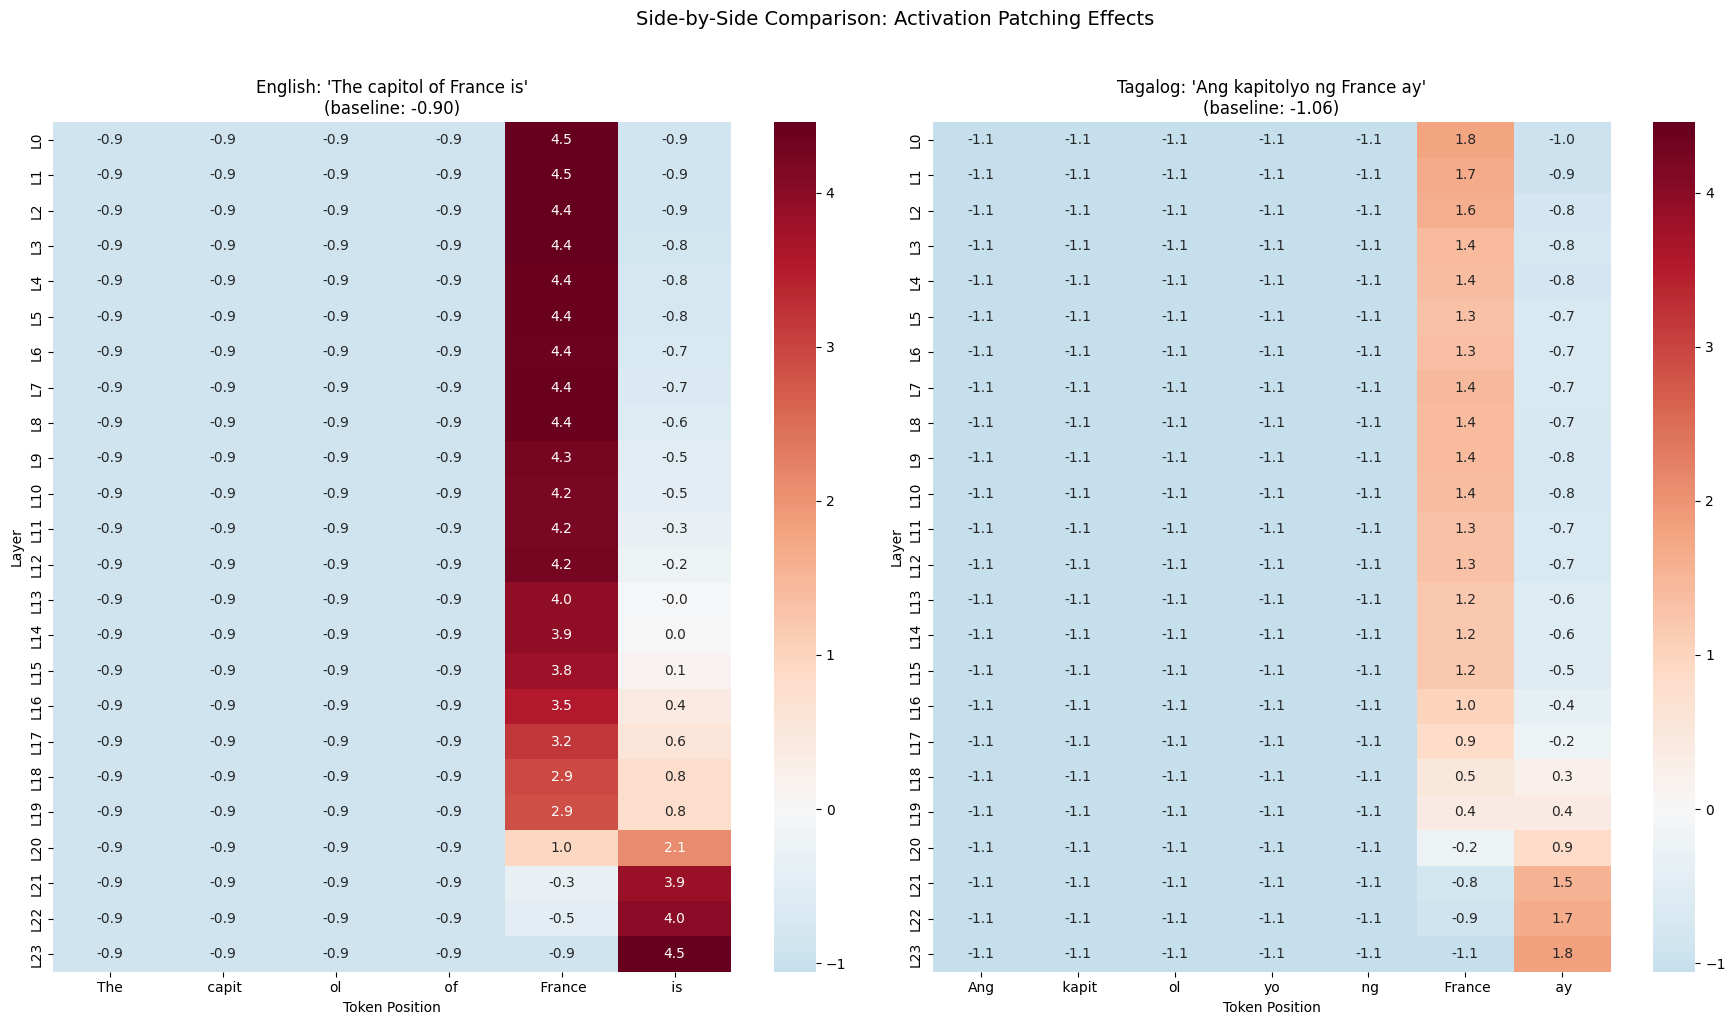

In [24]:
# Plot 1: Side-by-side heatmaps with shared color scale
# This lets you visually compare the patterns directly

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Find global min/max for consistent color scaling
vmin = min(english_heatmap_data.min(), tagalog_heatmap_data.min())
vmax = max(english_heatmap_data.max(), tagalog_heatmap_data.max())

# English heatmap
sns.heatmap(
    english_heatmap_data, 
    ax=axes[0],
    annot=True, 
    fmt=".1f", 
    xticklabels=english_str_tokens, 
    yticklabels=[f"L{i}" for i in range(n_layers)],
    cmap="RdBu_r", 
    center=0,
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title(f"English: 'The capitol of France is'\n(baseline: {english_base_score:.2f})")
axes[0].set_xlabel("Token Position")
axes[0].set_ylabel("Layer")

# Tagalog heatmap
sns.heatmap(
    tagalog_heatmap_data, 
    ax=axes[1],
    annot=True, 
    fmt=".1f", 
    xticklabels=tagalog_str_tokens, 
    yticklabels=[f"L{i}" for i in range(n_layers)],
    cmap="RdBu_r", 
    center=0,
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title(f"Tagalog: 'Ang kapitolyo ng France ay'\n(baseline: {tagalog_base_score:.2f})")
axes[1].set_xlabel("Token Position")
axes[1].set_ylabel("Layer")

plt.suptitle("Side-by-Side Comparison: Activation Patching Effects", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("lab3_plots/comparison_side_by_side.png", dpi=150, bbox_inches='tight')
plt.show()

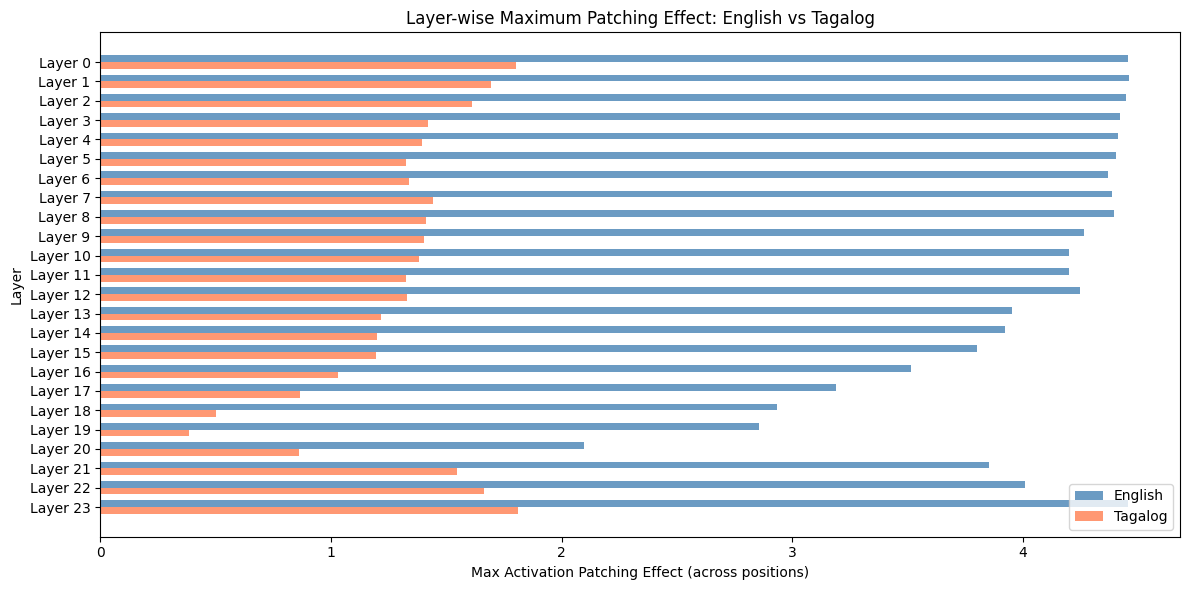


Layer-wise comparison summary:
Layer       English Max  Tagalog Max   Difference
------------------------------------------------
Layer 0            4.45         1.80         2.65
Layer 1            4.46         1.69         2.77
Layer 2            4.45         1.61         2.83
Layer 3            4.42         1.42         3.00
Layer 4            4.41         1.39         3.02
Layer 5            4.40         1.32         3.08
Layer 6            4.37         1.34         3.03
Layer 7            4.38         1.44         2.94
Layer 8            4.40         1.41         2.98
Layer 9            4.26         1.40         2.86
Layer 10           4.20         1.38         2.82
Layer 11           4.20         1.32         2.88
Layer 12           4.25         1.33         2.91
Layer 13           3.95         1.22         2.73
Layer 14           3.92         1.20         2.72
Layer 15           3.80         1.20         2.60
Layer 16           3.52         1.03         2.49
Layer 17           

In [25]:
# Plot 2: Layer-wise Maximum Activation Comparison
# This aggregates across positions to show which layers are most important for each language

english_layer_max = english_heatmap_data.max(axis=1)
tagalog_layer_max = tagalog_heatmap_data.max(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

layers = np.arange(n_layers)
width = 0.35

bars1 = ax.barh(layers - width/2, english_layer_max, width, label='English', color='steelblue', alpha=0.8)
bars2 = ax.barh(layers + width/2, tagalog_layer_max, width, label='Tagalog', color='coral', alpha=0.8)

ax.set_xlabel('Max Activation Patching Effect (across positions)')
ax.set_ylabel('Layer')
ax.set_yticks(layers)
ax.set_yticklabels([f'Layer {i}' for i in layers])
ax.legend()
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_title('Layer-wise Maximum Patching Effect: English vs Tagalog')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig("lab3_plots/comparison_layer_max.png", dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nLayer-wise comparison summary:")
print(f"{'Layer':<10} {'English Max':>12} {'Tagalog Max':>12} {'Difference':>12}")
print("-" * 48)
for i in range(n_layers):
    diff = english_layer_max[i] - tagalog_layer_max[i]
    print(f"Layer {i:<4} {english_layer_max[i]:>12.2f} {tagalog_layer_max[i]:>12.2f} {diff:>12.2f}")

# Attention Head Patching Experiment

Now we extend our analysis from layer/position patching to **individual attention head patching**. 

Instead of patching the entire residual stream at a layer, we patch the output of individual attention heads (using the `hook_z` activation in TransformerLens). This gives us a finer-grained view of which specific heads are responsible for recalling factual knowledge like "Paris is the capital of France."

**Hypothesis**: If the same neurons/heads encode factual knowledge across languages, we should see similar attention head importance patterns for English and Tagalog queries about "Paris."

In [5]:
# Setup for attention head patching
# Get model configuration
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads

print(f"Model: {model.cfg.model_name}")
print(f"Layers: {n_layers}, Heads per layer: {n_heads}")
print(f"Total attention heads: {n_layers * n_heads}")

Model: bloom-560m
Layers: 24, Heads per layer: 16
Total attention heads: 384


In [6]:
# Define hook function for patching individual attention head outputs
def make_head_patch_hook(layer, head, clean_cache):
    """
    Create a hook that patches the output of a specific attention head.
    
    The hook_z activation has shape [batch, pos, head, d_head] and represents
    the output of each attention head before being combined by W_O.
    """
    def hook(corrupted_z, hook):
        # corrupted_z shape: [batch, pos, head, d_head]
        # Patch only the specified head across all positions
        corrupted_z[:, :, head, :] = clean_cache[hook.name][:, :, head, :]
        return corrupted_z
    return hook

## English Attention Head Patching

In [7]:
# English prompts for attention head patching
eng_clean_prompt = "The capitol of France is"
eng_corrupted_prompt = "The capitol of Russia is"
eng_clean_answer = " Paris"
eng_corrupted_answer = " Moscow"

# Get token IDs
eng_clean_token = model.to_single_token(eng_clean_answer)
eng_corrupted_token = model.to_single_token(eng_corrupted_answer)

# Get clean cache
_, eng_clean_cache = model.run_with_cache(eng_clean_prompt)

# Get baseline (corrupted) score
eng_corrupted_logits = model(eng_corrupted_prompt)
eng_head_base_score = (eng_corrupted_logits[0, -1, eng_clean_token] - 
                       eng_corrupted_logits[0, -1, eng_corrupted_token]).item()

print(f"English baseline score (corrupted): {eng_head_base_score:.2f}")

English baseline score (corrupted): -0.90


In [8]:
# Run attention head patching for English
eng_head_patching_results = np.zeros((n_layers, n_heads))

print("Running attention head patching for English... (This may take a few minutes)")

for layer in range(n_layers):
    for head in range(n_heads):
        # Hook name for the attention head output (z) at this layer
        hook_name = f"blocks.{layer}.attn.hook_z"
        
        # Run with the patch hook
        patched_logits = model.run_with_hooks(
            eng_corrupted_prompt,
            fwd_hooks=[(hook_name, make_head_patch_hook(layer, head, eng_clean_cache))]
        )
        
        # Calculate score: difference in logits between clean and corrupted answer
        score = (patched_logits[0, -1, eng_clean_token] - 
                 patched_logits[0, -1, eng_corrupted_token]).item()
        
        eng_head_patching_results[layer, head] = score
    
    # Progress indicator
    if (layer + 1) % 6 == 0:
        print(f"  Completed layer {layer + 1}/{n_layers}")

print("English attention head patching complete!")

Running attention head patching for English... (This may take a few minutes)
  Completed layer 6/24
  Completed layer 12/24
  Completed layer 18/24
  Completed layer 24/24
English attention head patching complete!


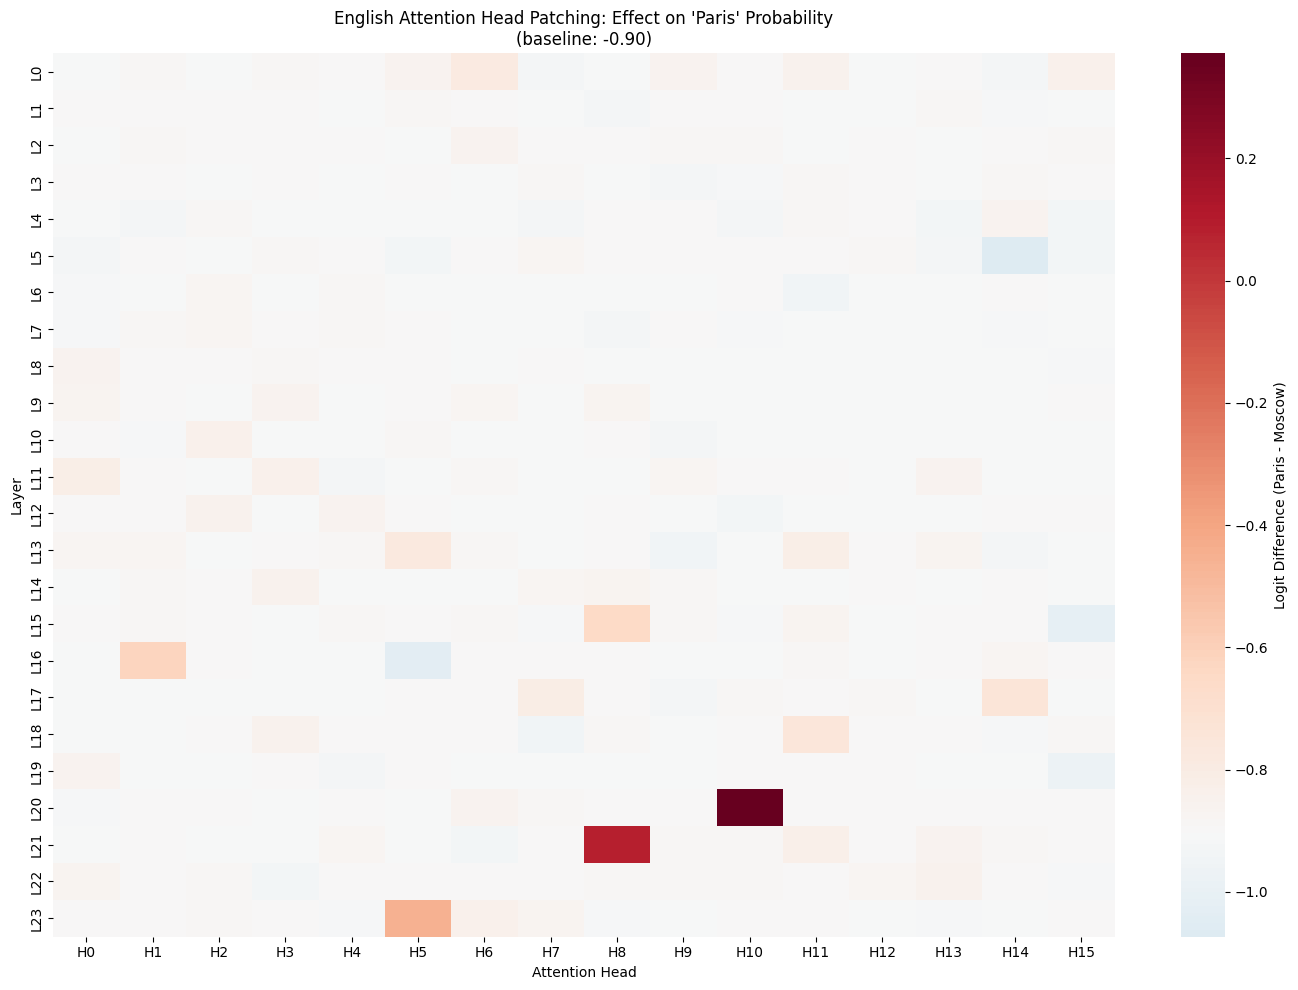


Top 10 most important attention heads for English 'Paris' recall:
  Layer 20, Head 10: effect = +1.28
  Layer 21, Head 8: effect = +0.99
  Layer 23, Head 5: effect = +0.45
  Layer 16, Head 1: effect = +0.29
  Layer 15, Head 8: effect = +0.26
  Layer 17, Head 14: effect = +0.16
  Layer 18, Head 11: effect = +0.15
  Layer 13, Head 5: effect = +0.12
  Layer 0, Head 6: effect = +0.12
  Layer 17, Head 7: effect = +0.09


In [9]:
# Visualize English attention head patching results
plt.figure(figsize=(14, 10))
sns.heatmap(
    eng_head_patching_results,
    annot=False,
    cmap="RdBu_r",
    center=eng_head_base_score,
    xticklabels=[f"H{i}" for i in range(n_heads)],
    yticklabels=[f"L{i}" for i in range(n_layers)],
    cbar_kws={'label': 'Logit Difference (Paris - Moscow)'}
)
plt.title(f"English Attention Head Patching: Effect on 'Paris' Probability\n(baseline: {eng_head_base_score:.2f})")
plt.xlabel("Attention Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.savefig("lab3_plots/english_head_patching.png", dpi=150, bbox_inches='tight')
plt.show()

# Find top contributing heads
eng_normalized = eng_head_patching_results - eng_head_base_score
top_k = 10
flat_indices = np.argsort(eng_normalized.flatten())[::-1][:top_k]
print(f"\nTop {top_k} most important attention heads for English 'Paris' recall:")
for idx in flat_indices:
    layer = idx // n_heads
    head = idx % n_heads
    effect = eng_normalized[layer, head]
    print(f"  Layer {layer}, Head {head}: effect = {effect:+.2f}")

## Tagalog Attention Head Patching

In [10]:
# Tagalog prompts for attention head patching
tag_clean_prompt = "Ang kapitolyo ng France ay"
tag_corrupted_prompt = "Ang kapitolyo ng Moscow ay"
tag_clean_answer = " Paris"
tag_corrupted_answer = " Moscow"

# Get token IDs (same as English since answers are the same)
tag_clean_token = model.to_single_token(tag_clean_answer)
tag_corrupted_token = model.to_single_token(tag_corrupted_answer)

# Get clean cache
_, tag_clean_cache = model.run_with_cache(tag_clean_prompt)

# Get baseline (corrupted) score
tag_corrupted_logits = model(tag_corrupted_prompt)
tag_head_base_score = (tag_corrupted_logits[0, -1, tag_clean_token] - 
                       tag_corrupted_logits[0, -1, tag_corrupted_token]).item()

print(f"Tagalog baseline score (corrupted): {tag_head_base_score:.2f}")

Tagalog baseline score (corrupted): -1.06


In [11]:
# Run attention head patching for Tagalog
tag_head_patching_results = np.zeros((n_layers, n_heads))

print("Running attention head patching for Tagalog... (This may take a few minutes)")

for layer in range(n_layers):
    for head in range(n_heads):
        # Hook name for the attention head output (z) at this layer
        hook_name = f"blocks.{layer}.attn.hook_z"
        
        # Run with the patch hook
        patched_logits = model.run_with_hooks(
            tag_corrupted_prompt,
            fwd_hooks=[(hook_name, make_head_patch_hook(layer, head, tag_clean_cache))]
        )
        
        # Calculate score: difference in logits between clean and corrupted answer
        score = (patched_logits[0, -1, tag_clean_token] - 
                 patched_logits[0, -1, tag_corrupted_token]).item()
        
        tag_head_patching_results[layer, head] = score
    
    # Progress indicator
    if (layer + 1) % 6 == 0:
        print(f"  Completed layer {layer + 1}/{n_layers}")

print("Tagalog attention head patching complete!")

Running attention head patching for Tagalog... (This may take a few minutes)
  Completed layer 6/24
  Completed layer 12/24
  Completed layer 18/24
  Completed layer 24/24
Tagalog attention head patching complete!


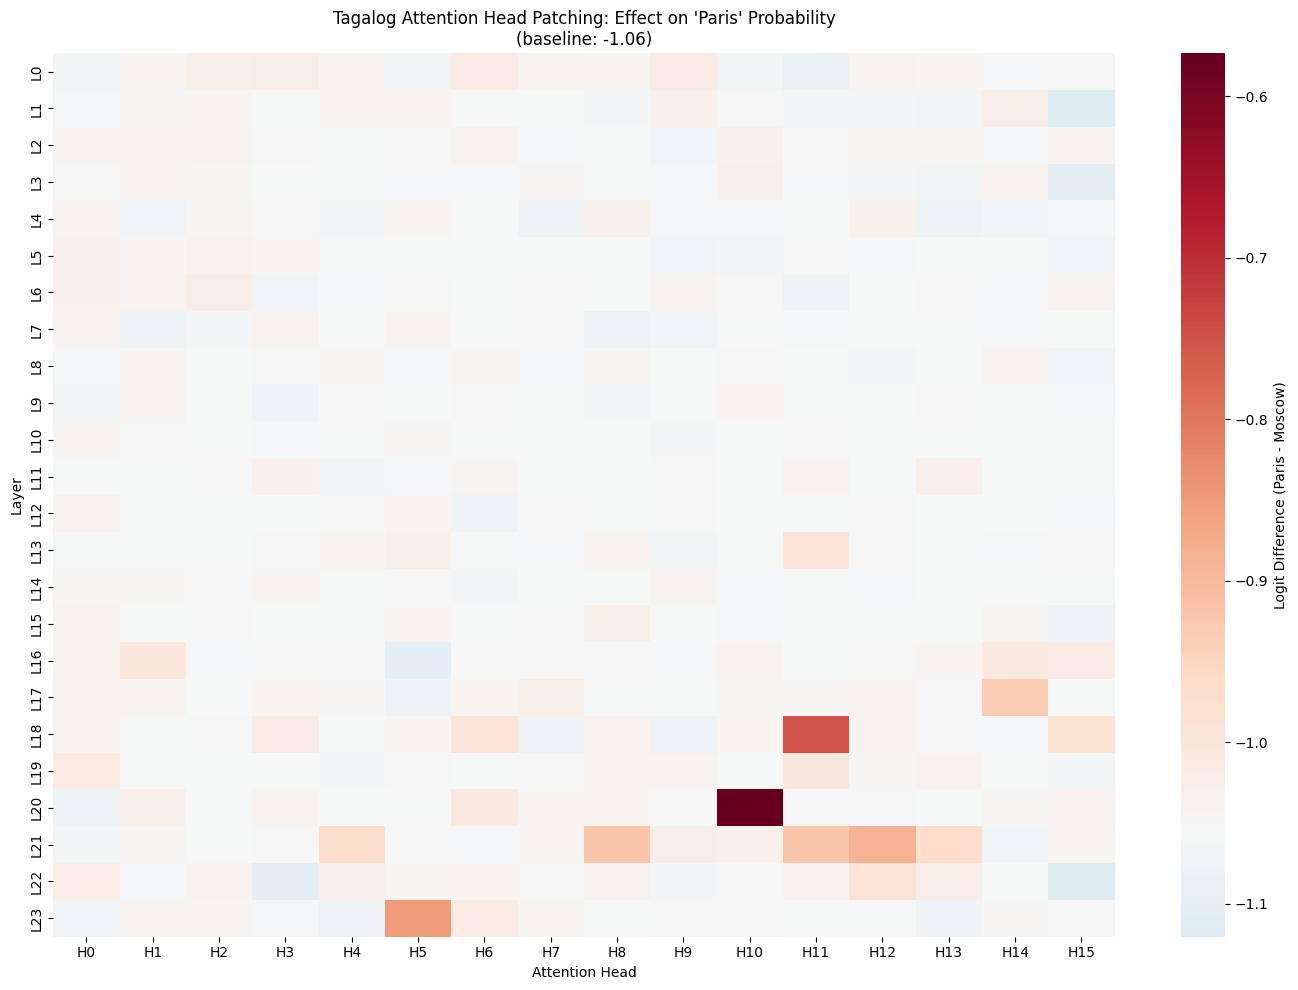


Top 10 most important attention heads for Tagalog 'Paris' recall:
  Layer 20, Head 10: effect = +0.48
  Layer 18, Head 11: effect = +0.30
  Layer 23, Head 5: effect = +0.21
  Layer 21, Head 12: effect = +0.17
  Layer 21, Head 8: effect = +0.13
  Layer 21, Head 11: effect = +0.13
  Layer 17, Head 14: effect = +0.12
  Layer 21, Head 13: effect = +0.09
  Layer 21, Head 4: effect = +0.08
  Layer 18, Head 15: effect = +0.07


In [13]:
# Visualize Tagalog attention head patching results
plt.figure(figsize=(14, 10))
sns.heatmap(
    tag_head_patching_results,
    annot=False,
    cmap="RdBu_r",
    center=tag_head_base_score,
    xticklabels=[f"H{i}" for i in range(n_heads)],
    yticklabels=[f"L{i}" for i in range(n_layers)],
    cbar_kws={'label': 'Logit Difference (Paris - Moscow)'}
)
plt.title(f"Tagalog Attention Head Patching: Effect on 'Paris' Probability\n(baseline: {tag_head_base_score:.2f})")
plt.xlabel("Attention Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.savefig("lab3_plots/tagalog_head_patching.png", dpi=150, bbox_inches='tight')
plt.show()

# Find top contributing heads
tag_normalized = tag_head_patching_results - tag_head_base_score
top_k = 10
flat_indices = np.argsort(tag_normalized.flatten())[::-1][:top_k]
print(f"\nTop {top_k} most important attention heads for Tagalog 'Paris' recall:")
for idx in flat_indices:
    layer = idx // n_heads
    head = idx % n_heads
    effect = tag_normalized[layer, head]
    print(f"  Layer {layer}, Head {head}: effect = {effect:+.2f}")

## Comparison: English vs Tagalog Attention Head Patching

Now let's compare the attention head patterns between English and Tagalog to see if the same heads are responsible for factual recall across languages.

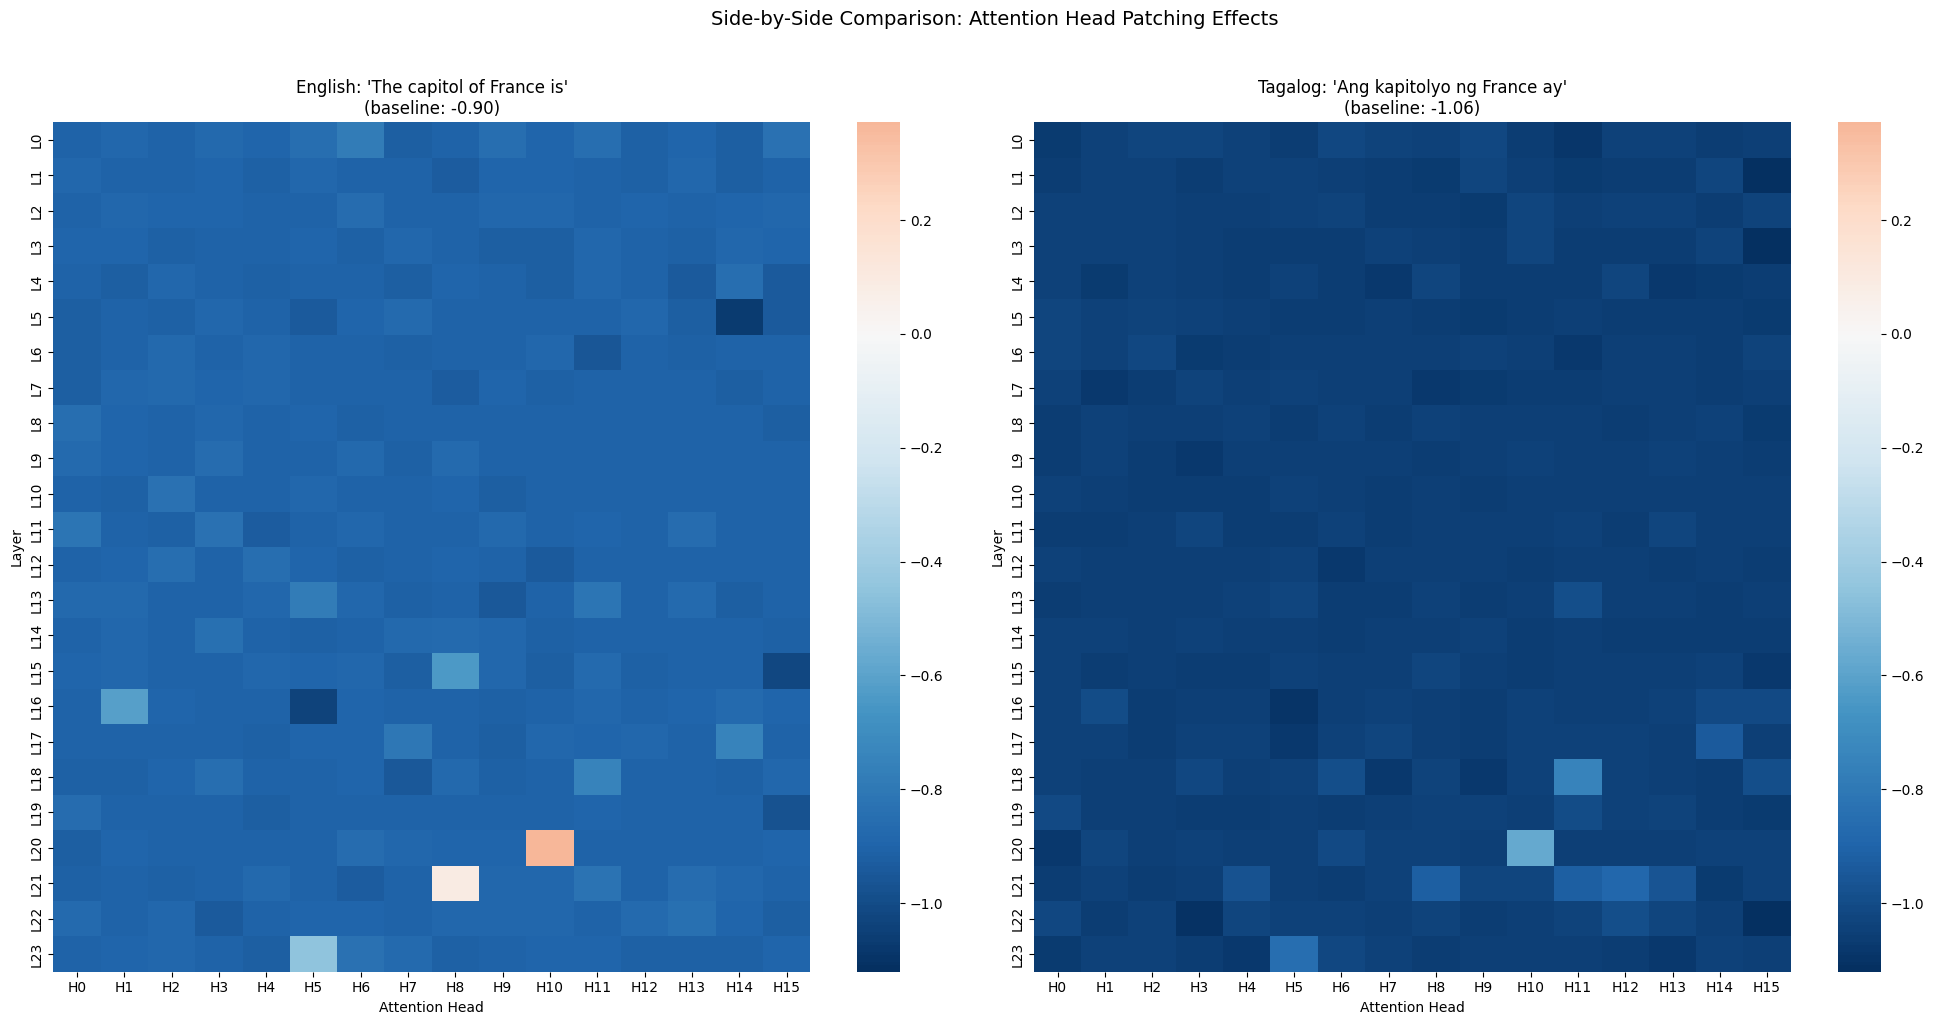

In [14]:
# Plot 1: Side-by-side heatmaps of attention head patching results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Find global min/max for consistent color scaling
vmin = min(eng_head_patching_results.min(), tag_head_patching_results.min())
vmax = max(eng_head_patching_results.max(), tag_head_patching_results.max())

# English heatmap
sns.heatmap(
    eng_head_patching_results,
    ax=axes[0],
    cmap="RdBu_r",
    center=0,
    vmin=vmin,
    vmax=vmax,
    xticklabels=[f"H{i}" for i in range(n_heads)],
    yticklabels=[f"L{i}" for i in range(n_layers)],
)
axes[0].set_title(f"English: 'The capitol of France is'\n(baseline: {eng_head_base_score:.2f})")
axes[0].set_xlabel("Attention Head")
axes[0].set_ylabel("Layer")

# Tagalog heatmap
sns.heatmap(
    tag_head_patching_results,
    ax=axes[1],
    cmap="RdBu_r",
    center=0,
    vmin=vmin,
    vmax=vmax,
    xticklabels=[f"H{i}" for i in range(n_heads)],
    yticklabels=[f"L{i}" for i in range(n_layers)],
)
axes[1].set_title(f"Tagalog: 'Ang kapitolyo ng France ay'\n(baseline: {tag_head_base_score:.2f})")
axes[1].set_xlabel("Attention Head")
axes[1].set_ylabel("Layer")

plt.suptitle("Side-by-Side Comparison: Attention Head Patching Effects", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("lab3_plots/head_comparison_side_by_side.png", dpi=150, bbox_inches='tight')
plt.show()

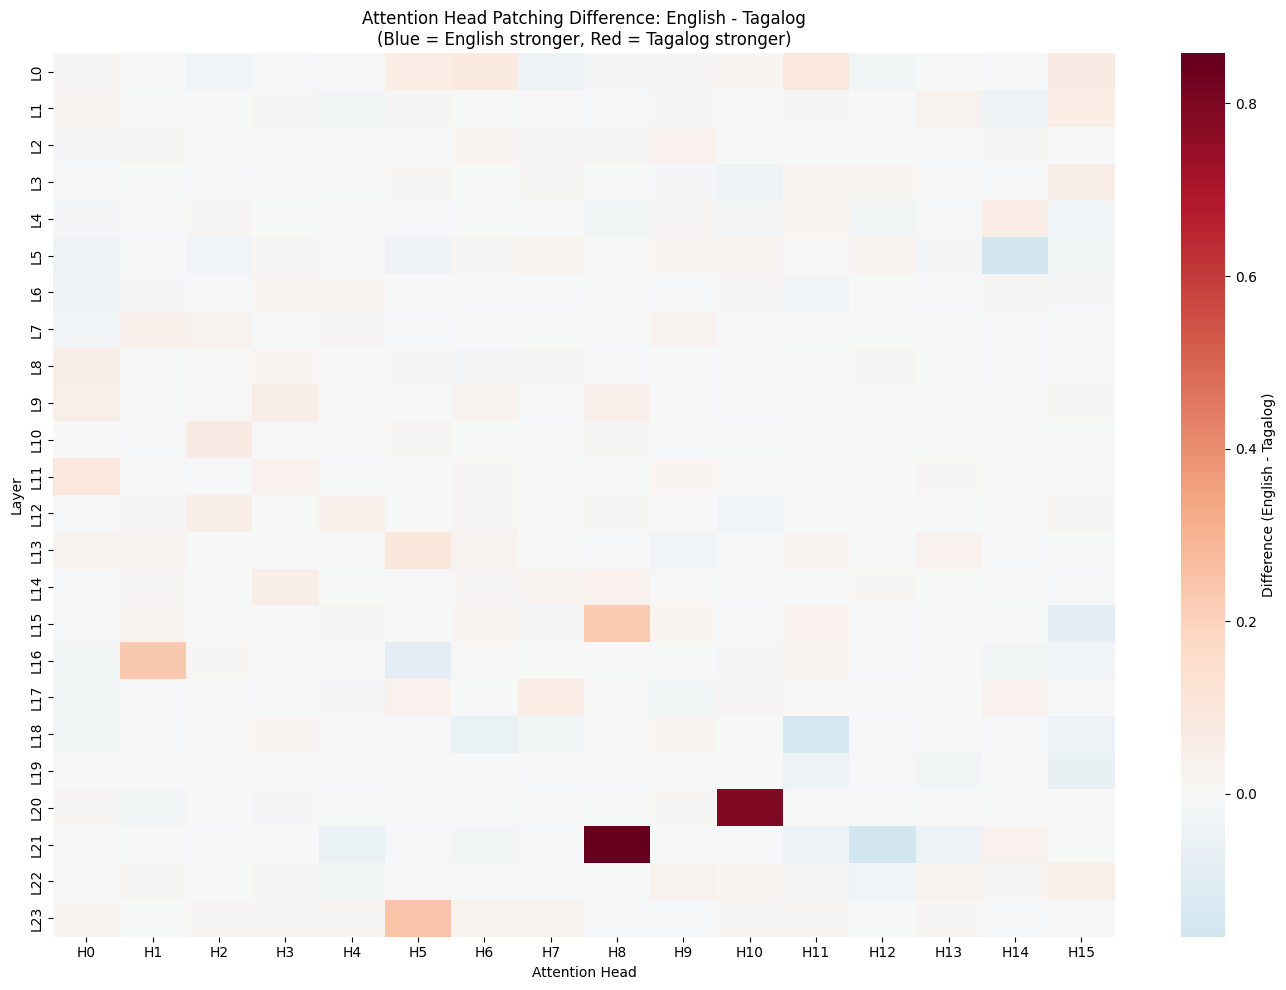


Heads with largest differences between languages:
  Layer 21, Head 8: diff = +0.86 (English stronger)
  Layer 20, Head 10: diff = +0.79 (English stronger)
  Layer 23, Head 5: diff = +0.25 (English stronger)
  Layer 16, Head 1: diff = +0.23 (English stronger)
  Layer 15, Head 8: diff = +0.23 (English stronger)
  Layer 21, Head 12: diff = -0.17 (Tagalog stronger)
  Layer 5, Head 14: diff = -0.17 (Tagalog stronger)
  Layer 18, Head 11: diff = -0.15 (Tagalog stronger)
  Layer 13, Head 5: diff = +0.09 (English stronger)
  Layer 0, Head 11: diff = +0.09 (English stronger)


In [15]:
# Plot 2: Difference heatmap - where do English and Tagalog differ?
head_diff = eng_normalized - tag_normalized

plt.figure(figsize=(14, 10))
sns.heatmap(
    head_diff,
    cmap="RdBu_r",
    center=0,
    xticklabels=[f"H{i}" for i in range(n_heads)],
    yticklabels=[f"L{i}" for i in range(n_layers)],
    cbar_kws={'label': 'Difference (English - Tagalog)'}
)
plt.title("Attention Head Patching Difference: English - Tagalog\n(Blue = English stronger, Red = Tagalog stronger)")
plt.xlabel("Attention Head")
plt.ylabel("Layer")
plt.tight_layout()
plt.savefig("lab3_plots/head_comparison_difference.png", dpi=150, bbox_inches='tight')
plt.show()

# Find heads with largest differences
print("\nHeads with largest differences between languages:")
flat_diff = head_diff.flatten()
top_diff_indices = np.argsort(np.abs(flat_diff))[::-1][:10]
for idx in top_diff_indices:
    layer = idx // n_heads
    head = idx % n_heads
    diff = head_diff[layer, head]
    direction = "English stronger" if diff > 0 else "Tagalog stronger"
    print(f"  Layer {layer}, Head {head}: diff = {diff:+.2f} ({direction})")

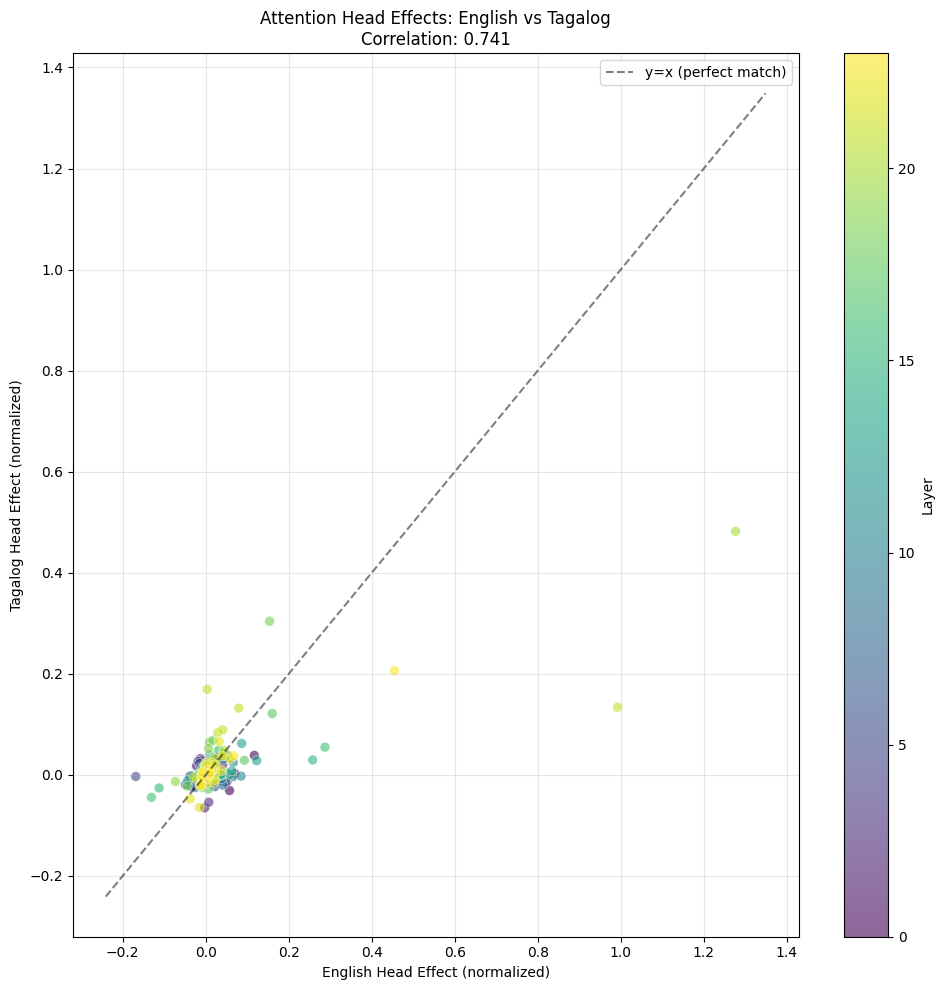


Overall correlation between English and Tagalog attention head effects: 0.741


In [16]:
# Plot 3: Scatter plot - correlation between English and Tagalog head effects
eng_flat = eng_normalized.flatten()
tag_flat = tag_normalized.flatten()

# Calculate correlation
head_correlation = np.corrcoef(eng_flat, tag_flat)[0, 1]

plt.figure(figsize=(10, 10))
scatter = plt.scatter(eng_flat, tag_flat, c=np.repeat(range(n_layers), n_heads), 
                      cmap='viridis', alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
plt.colorbar(scatter, label='Layer')

# Add diagonal line (perfect correlation)
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'k--', alpha=0.5, label='y=x (perfect match)')

plt.xlabel('English Head Effect (normalized)')
plt.ylabel('Tagalog Head Effect (normalized)')
plt.title(f'Attention Head Effects: English vs Tagalog\nCorrelation: {head_correlation:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("lab3_plots/head_comparison_scatter.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOverall correlation between English and Tagalog attention head effects: {head_correlation:.3f}")

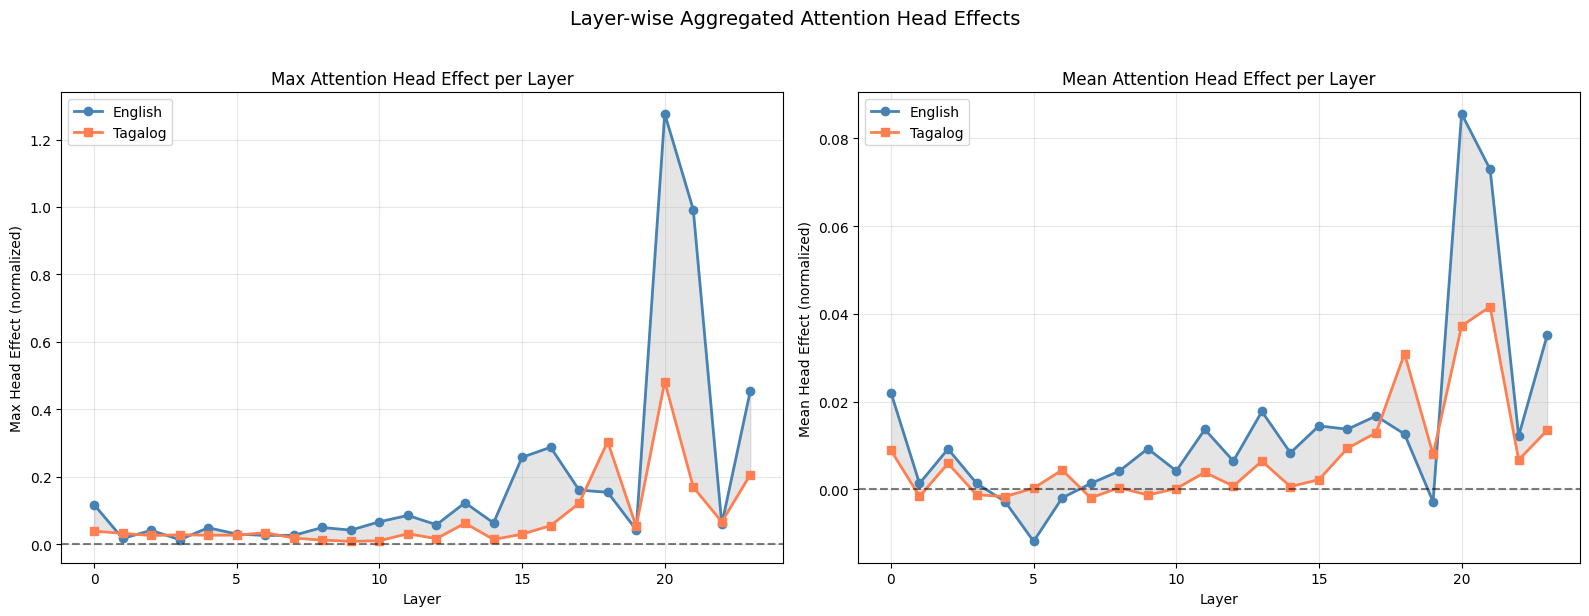


Layer-wise correlation (max head effect): 0.804
Layer-wise correlation (mean head effect): 0.847


In [17]:
# Plot 4: Layer-wise aggregation - max effect per layer across all heads
eng_layer_max_head = eng_normalized.max(axis=1)
tag_layer_max_head = tag_normalized.max(axis=1)
eng_layer_mean_head = eng_normalized.mean(axis=1)
tag_layer_mean_head = tag_normalized.mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Max effect per layer
axes[0].plot(range(n_layers), eng_layer_max_head, 'o-', label='English', color='steelblue', linewidth=2, markersize=6)
axes[0].plot(range(n_layers), tag_layer_max_head, 's-', label='Tagalog', color='coral', linewidth=2, markersize=6)
axes[0].fill_between(range(n_layers), eng_layer_max_head, tag_layer_max_head, alpha=0.2, color='gray')
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Max Head Effect (normalized)')
axes[0].set_title('Max Attention Head Effect per Layer')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Mean effect per layer
axes[1].plot(range(n_layers), eng_layer_mean_head, 'o-', label='English', color='steelblue', linewidth=2, markersize=6)
axes[1].plot(range(n_layers), tag_layer_mean_head, 's-', label='Tagalog', color='coral', linewidth=2, markersize=6)
axes[1].fill_between(range(n_layers), eng_layer_mean_head, tag_layer_mean_head, alpha=0.2, color='gray')
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Mean Head Effect (normalized)')
axes[1].set_title('Mean Attention Head Effect per Layer')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.suptitle('Layer-wise Aggregated Attention Head Effects', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("lab3_plots/head_comparison_layer_profiles.png", dpi=150, bbox_inches='tight')
plt.show()

# Compute layer-wise correlations
layer_max_corr = np.corrcoef(eng_layer_max_head, tag_layer_max_head)[0, 1]
layer_mean_corr = np.corrcoef(eng_layer_mean_head, tag_layer_mean_head)[0, 1]
print(f"\nLayer-wise correlation (max head effect): {layer_max_corr:.3f}")
print(f"Layer-wise correlation (mean head effect): {layer_mean_corr:.3f}")

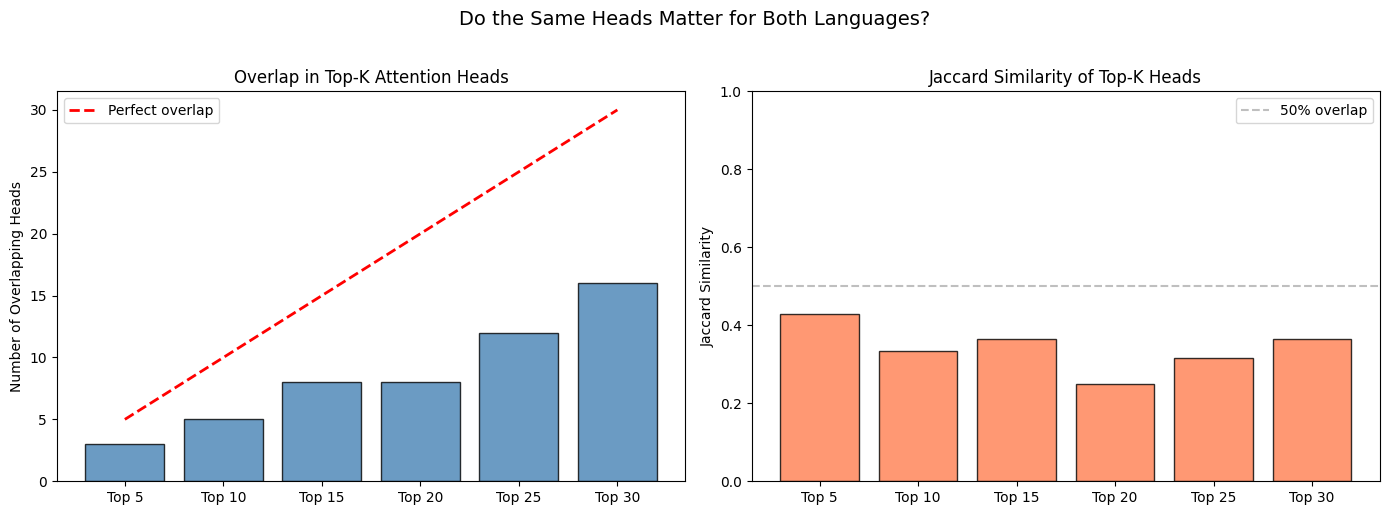


Top 10 heads overlap analysis:
  English top 10: [(0, 6), (13, 5), (15, 8), (16, 1), (17, 7), (17, 14), (18, 11), (20, 10), (21, 8), (23, 5)]
  Tagalog top 10: [(17, 14), (18, 11), (18, 15), (20, 10), (21, 4), (21, 8), (21, 11), (21, 12), (21, 13), (23, 5)]
  Common heads: [(17, 14), (18, 11), (20, 10), (21, 8), (23, 5)]
  Overlap: 5/10 (50%)


In [18]:
# Plot 5: Top heads overlap analysis
# Do the same heads appear in the top-k for both languages?

def get_top_heads(results_normalized, k=20):
    """Return set of (layer, head) tuples for top k heads."""
    flat_indices = np.argsort(results_normalized.flatten())[::-1][:k]
    heads = set()
    for idx in flat_indices:
        layer = idx // n_heads
        head = idx % n_heads
        heads.add((layer, head))
    return heads

# Get top heads for each language
top_k_values = [5, 10, 15, 20, 25, 30]
overlap_counts = []
jaccard_scores = []

for k in top_k_values:
    eng_top = get_top_heads(eng_normalized, k)
    tag_top = get_top_heads(tag_normalized, k)
    overlap = len(eng_top.intersection(tag_top))
    jaccard = len(eng_top.intersection(tag_top)) / len(eng_top.union(tag_top))
    overlap_counts.append(overlap)
    jaccard_scores.append(jaccard)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overlap count
axes[0].bar(range(len(top_k_values)), overlap_counts, color='steelblue', alpha=0.8, edgecolor='black')
axes[0].plot(range(len(top_k_values)), top_k_values, 'r--', label='Perfect overlap', linewidth=2)
axes[0].set_xticks(range(len(top_k_values)))
axes[0].set_xticklabels([f'Top {k}' for k in top_k_values])
axes[0].set_ylabel('Number of Overlapping Heads')
axes[0].set_title('Overlap in Top-K Attention Heads')
axes[0].legend()

# Jaccard similarity
axes[1].bar(range(len(top_k_values)), jaccard_scores, color='coral', alpha=0.8, edgecolor='black')
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% overlap')
axes[1].set_xticks(range(len(top_k_values)))
axes[1].set_xticklabels([f'Top {k}' for k in top_k_values])
axes[1].set_ylabel('Jaccard Similarity')
axes[1].set_title('Jaccard Similarity of Top-K Heads')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.suptitle('Do the Same Heads Matter for Both Languages?', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("lab3_plots/head_comparison_top_overlap.png", dpi=150, bbox_inches='tight')
plt.show()

# Print detailed overlap for top 10
print("\nTop 10 heads overlap analysis:")
eng_top10 = get_top_heads(eng_normalized, 10)
tag_top10 = get_top_heads(tag_normalized, 10)
common_heads = eng_top10.intersection(tag_top10)
print(f"  English top 10: {sorted(eng_top10)}")
print(f"  Tagalog top 10: {sorted(tag_top10)}")
print(f"  Common heads: {sorted(common_heads)}")
print(f"  Overlap: {len(common_heads)}/10 ({len(common_heads)*10}%)")

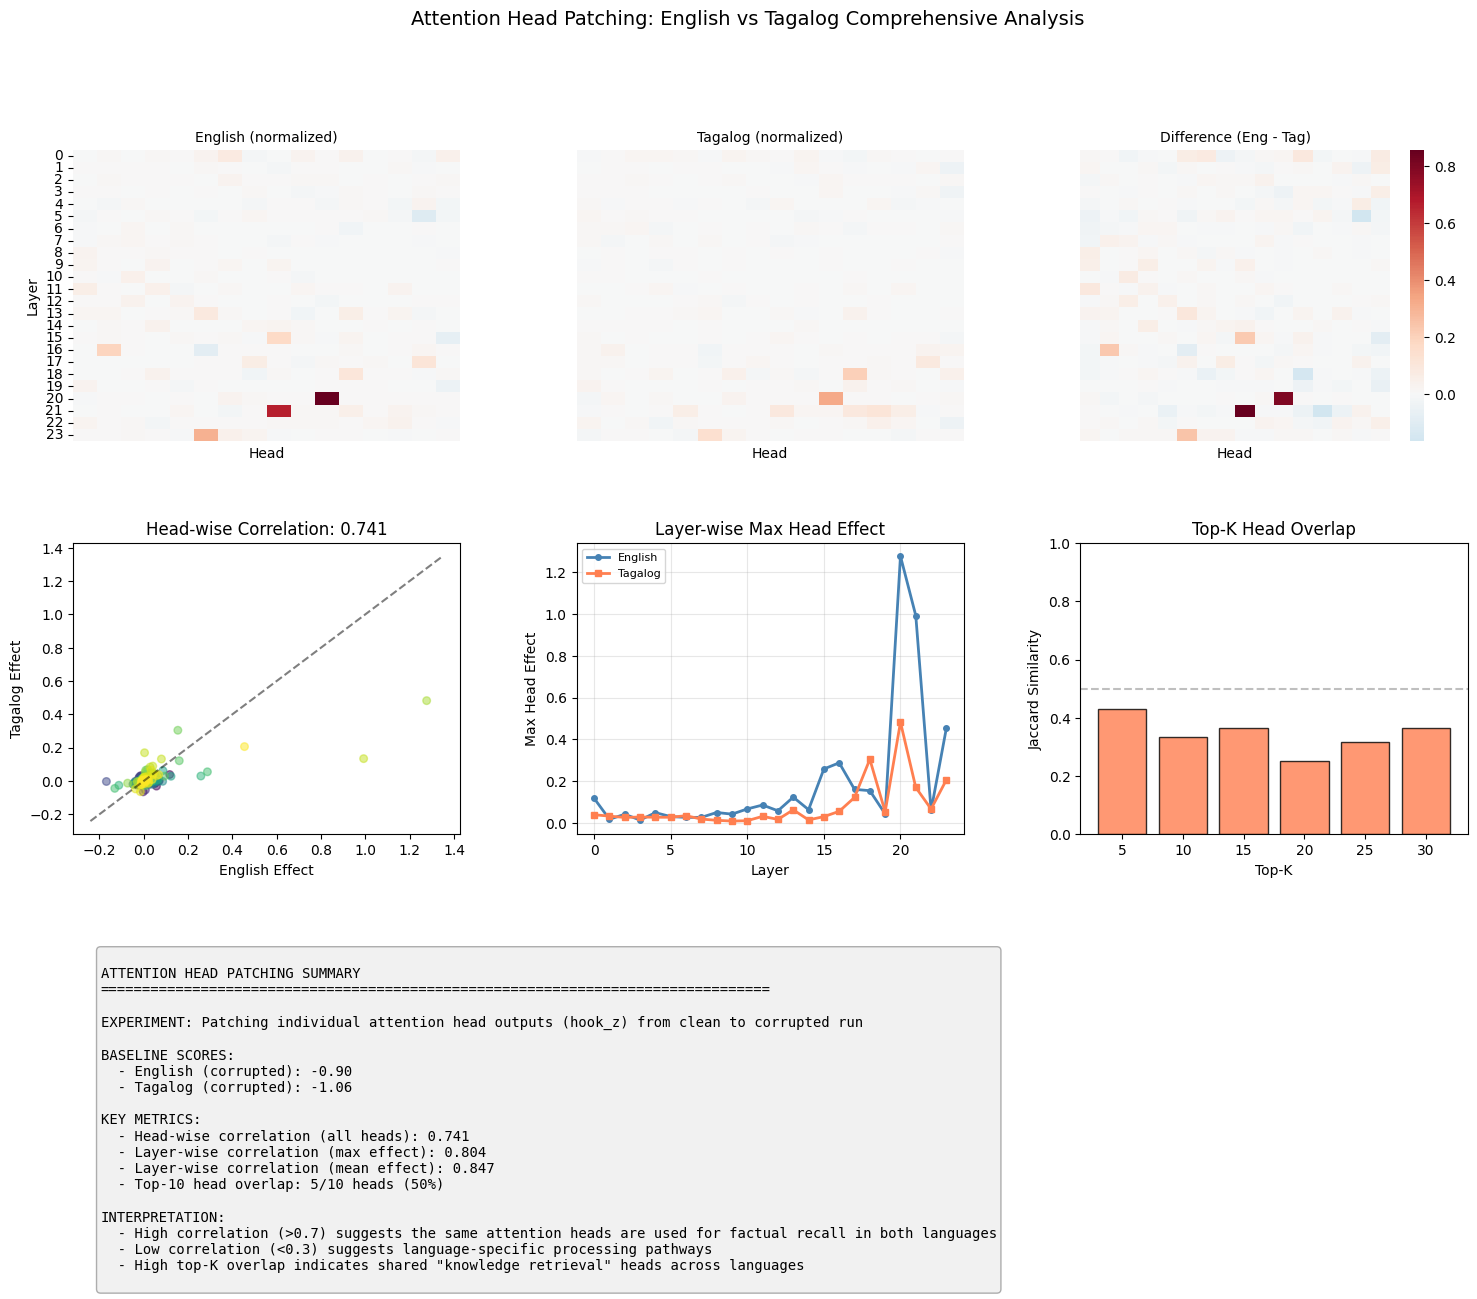

In [19]:
# Plot 6: Comprehensive summary figure
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Top row: Side-by-side heatmaps
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

vmin = min(eng_normalized.min(), tag_normalized.min())
vmax = max(eng_normalized.max(), tag_normalized.max())

sns.heatmap(eng_normalized, ax=ax1, cmap="RdBu_r", center=0, vmin=vmin, vmax=vmax,
            cbar=False, xticklabels=False, yticklabels=[f'{i}' for i in range(n_layers)])
ax1.set_title('English (normalized)', fontsize=10)
ax1.set_ylabel('Layer')
ax1.set_xlabel('Head')

sns.heatmap(tag_normalized, ax=ax2, cmap="RdBu_r", center=0, vmin=vmin, vmax=vmax,
            cbar=False, xticklabels=False, yticklabels=False)
ax2.set_title('Tagalog (normalized)', fontsize=10)
ax2.set_xlabel('Head')

sns.heatmap(head_diff, ax=ax3, cmap="RdBu_r", center=0,
            cbar=True, xticklabels=False, yticklabels=False)
ax3.set_title('Difference (Eng - Tag)', fontsize=10)
ax3.set_xlabel('Head')

# Middle left: Scatter plot
ax4 = fig.add_subplot(gs[1, 0])
scatter = ax4.scatter(eng_flat, tag_flat, c=np.repeat(range(n_layers), n_heads),
                      cmap='viridis', alpha=0.5, s=30)
lims = [min(ax4.get_xlim()[0], ax4.get_ylim()[0]), max(ax4.get_xlim()[1], ax4.get_ylim()[1])]
ax4.plot(lims, lims, 'k--', alpha=0.5)
ax4.set_xlabel('English Effect')
ax4.set_ylabel('Tagalog Effect')
ax4.set_title(f'Head-wise Correlation: {head_correlation:.3f}')

# Middle center: Layer profiles
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(range(n_layers), eng_layer_max_head, 'o-', label='English', color='steelblue', linewidth=2, markersize=4)
ax5.plot(range(n_layers), tag_layer_max_head, 's-', label='Tagalog', color='coral', linewidth=2, markersize=4)
ax5.set_xlabel('Layer')
ax5.set_ylabel('Max Head Effect')
ax5.set_title('Layer-wise Max Head Effect')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# Middle right: Overlap analysis
ax6 = fig.add_subplot(gs[1, 2])
ax6.bar(range(len(top_k_values)), jaccard_scores, color='coral', alpha=0.8, edgecolor='black')
ax6.set_xticks(range(len(top_k_values)))
ax6.set_xticklabels([f'{k}' for k in top_k_values])
ax6.set_xlabel('Top-K')
ax6.set_ylabel('Jaccard Similarity')
ax6.set_title('Top-K Head Overlap')
ax6.set_ylim(0, 1)
ax6.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Bottom row: Summary text
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

# Calculate additional statistics
top10_overlap = len(get_top_heads(eng_normalized, 10).intersection(get_top_heads(tag_normalized, 10)))

summary_text = f"""
ATTENTION HEAD PATCHING SUMMARY
{'='*80}

EXPERIMENT: Patching individual attention head outputs (hook_z) from clean to corrupted run

BASELINE SCORES:
  - English (corrupted): {eng_head_base_score:.2f}
  - Tagalog (corrupted): {tag_head_base_score:.2f}

KEY METRICS:
  - Head-wise correlation (all heads): {head_correlation:.3f}
  - Layer-wise correlation (max effect): {layer_max_corr:.3f}
  - Layer-wise correlation (mean effect): {layer_mean_corr:.3f}
  - Top-10 head overlap: {top10_overlap}/10 heads ({top10_overlap*10}%)

INTERPRETATION:
  - High correlation (>0.7) suggests the same attention heads are used for factual recall in both languages
  - Low correlation (<0.3) suggests language-specific processing pathways
  - High top-K overlap indicates shared "knowledge retrieval" heads across languages
"""
ax7.text(0.02, 0.95, summary_text, transform=ax7.transAxes, fontsize=10, verticalalignment='top',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

plt.suptitle('Attention Head Patching: English vs Tagalog Comprehensive Analysis', fontsize=14, y=0.98)
plt.savefig("lab3_plots/head_comparison_summary.png", dpi=150, bbox_inches='tight')
plt.show()

## Combined Analysis: Residual Stream vs Attention Head Patching

Let's compare our two levels of analysis to see if they tell a consistent story about cross-lingual factual recall.

NameError: name 'english_heatmap_data' is not defined

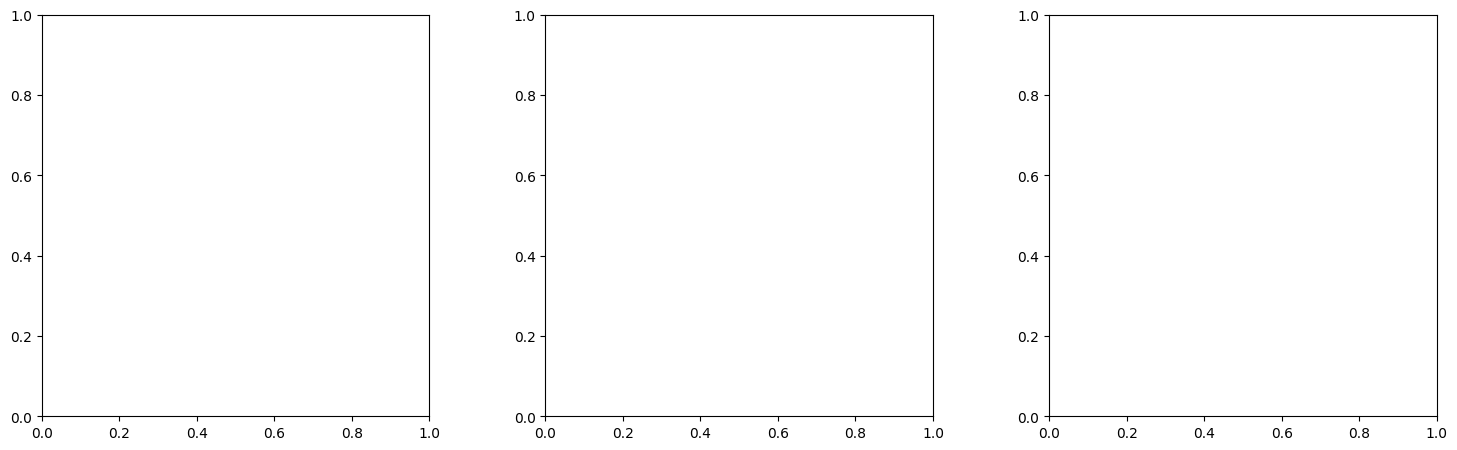

In [20]:
# Combined comparison: Residual Stream Patching vs Attention Head Patching

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# --- Top Row: Residual Stream Patching ---
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Use the earlier layer/position patching results (normalized)
eng_resid_normalized = english_heatmap_data - english_base_score
tag_resid_normalized = tagalog_heatmap_data - tagalog_base_score

vmin_resid = min(eng_resid_normalized.min(), tag_resid_normalized.min())
vmax_resid = max(eng_resid_normalized.max(), tag_resid_normalized.max())

sns.heatmap(eng_resid_normalized, ax=ax1, cmap="RdBu_r", center=0, 
            cbar=False, xticklabels=english_str_tokens, yticklabels=[f'{i}' for i in range(n_layers)])
ax1.set_title('English: Residual Stream', fontsize=10)
ax1.set_ylabel('Layer')
ax1.set_xlabel('Position')

sns.heatmap(tag_resid_normalized, ax=ax2, cmap="RdBu_r", center=0,
            cbar=False, xticklabels=tagalog_str_tokens, yticklabels=False)
ax2.set_title('Tagalog: Residual Stream', fontsize=10)
ax2.set_xlabel('Position')

# Residual stream layer-wise correlation
resid_layer_max_eng = eng_resid_normalized.max(axis=1)
resid_layer_max_tag = tag_resid_normalized.max(axis=1)
ax3.scatter(resid_layer_max_eng, resid_layer_max_tag, c=range(n_layers), cmap='viridis', s=80, edgecolors='black')
for i in range(n_layers):
    ax3.annotate(f'L{i}', (resid_layer_max_eng[i], resid_layer_max_tag[i]), 
                 textcoords="offset points", xytext=(3, 3), fontsize=7)
lims = [min(ax3.get_xlim()[0], ax3.get_ylim()[0]), max(ax3.get_xlim()[1], ax3.get_ylim()[1])]
ax3.plot(lims, lims, 'k--', alpha=0.5)
resid_corr = np.corrcoef(resid_layer_max_eng, resid_layer_max_tag)[0, 1]
ax3.set_title(f'Layer Correlation: {resid_corr:.3f}', fontsize=10)
ax3.set_xlabel('English Max Effect')
ax3.set_ylabel('Tagalog Max Effect')

# --- Bottom Row: Attention Head Patching ---
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

vmin_head = min(eng_normalized.min(), tag_normalized.min())
vmax_head = max(eng_normalized.max(), tag_normalized.max())

sns.heatmap(eng_normalized, ax=ax4, cmap="RdBu_r", center=0, vmin=vmin_head, vmax=vmax_head,
            cbar=False, xticklabels=False, yticklabels=[f'{i}' for i in range(n_layers)])
ax4.set_title('English: Attention Heads', fontsize=10)
ax4.set_ylabel('Layer')
ax4.set_xlabel('Head')

sns.heatmap(tag_normalized, ax=ax5, cmap="RdBu_r", center=0, vmin=vmin_head, vmax=vmax_head,
            cbar=False, xticklabels=False, yticklabels=False)
ax5.set_title('Tagalog: Attention Heads', fontsize=10)
ax5.set_xlabel('Head')

# Attention head correlation scatter
ax6.scatter(eng_flat, tag_flat, c=np.repeat(range(n_layers), n_heads), 
            cmap='viridis', alpha=0.4, s=20)
lims = [min(ax6.get_xlim()[0], ax6.get_ylim()[0]), max(ax6.get_xlim()[1], ax6.get_ylim()[1])]
ax6.plot(lims, lims, 'k--', alpha=0.5)
ax6.set_title(f'Head Correlation: {head_correlation:.3f}', fontsize=10)
ax6.set_xlabel('English Head Effect')
ax6.set_ylabel('Tagalog Head Effect')

plt.suptitle('Comparison: Residual Stream vs Attention Head Patching', fontsize=14, y=0.98)
plt.savefig("lab3_plots/combined_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Print summary comparison
print("\n" + "="*70)
print("COMBINED ANALYSIS SUMMARY")
print("="*70)
print(f"\nRESIDUAL STREAM PATCHING (Layer x Position):")
print(f"  - Layer-wise correlation (max effect): {resid_corr:.3f}")
print(f"  - English baseline: {english_base_score:.2f}")
print(f"  - Tagalog baseline: {tagalog_base_score:.2f}")

print(f"\nATTENTION HEAD PATCHING (Layer x Head):")
print(f"  - Head-wise correlation (all {n_layers*n_heads} heads): {head_correlation:.3f}")
print(f"  - Layer-wise correlation (max head): {layer_max_corr:.3f}")
print(f"  - English baseline: {eng_head_base_score:.2f}")
print(f"  - Tagalog baseline: {tag_head_base_score:.2f}")
print(f"  - Top-10 head overlap: {top10_overlap}/10 ({top10_overlap*10}%)")

print(f"\nCONCLUSION:")
if head_correlation > 0.5 and resid_corr > 0.5:
    print("  Both analyses suggest SHARED representations for 'Paris' across languages.")
    print("  The same layers and attention heads appear important for both English and Tagalog.")
elif head_correlation < 0.3 and resid_corr < 0.3:
    print("  Both analyses suggest DISTINCT representations for each language.")
    print("  Different layers/heads are used for English vs Tagalog factual recall.")
else:
    print("  Mixed results - further investigation needed.")
    print(f"  Residual stream correlation: {resid_corr:.3f}")
    print(f"  Attention head correlation: {head_correlation:.3f}")